In [208]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
import seaborn as sns
# import exoplanet as xo

In [189]:
## Download Data
galaxies_df = pd.read_csv('/Users/caleb/Downloads/asu(4).tsv',delimiter=';',skiprows=104)
galaxies_df = galaxies_df.drop([0,1])
galaxies_df = galaxies_df.drop(['l_FUV','l_Hamag','l_HImag','l_MHI','K+04'],axis=1)

# drop galaxies with no type
no_type = []
# rows missing galaxy type
for i in range(2,len(galaxies_df)):
    if np.char.isspace(galaxies_df['TT'][i]):
        no_type.append(i)

galaxies_df = galaxies_df.drop(no_type)




galaxies_df[20:30]

,_RAJ2000,_DEJ2000,Name,Nd,RAJ2000,DEJ2000,a26,FUV,Bmag,Hamag,...,Dist,A26,i,vAmp,<Bmu>,M26,MHI,Vlg,Ti5,SimbadName
22,007.537083,+46.851944,And XXV,4,00 30 08.9,+46 51 07,4.80,23.00,15.90,,...,0.81,1.27,52,,27.8,,,170,2.9,And XXV
23,007.843750,-22.765833,ESO473-024,7,00 31 22.5,-22 45 57,1.55,16.92,16.38,19.06,...,9.90,4.44,63,22,25.9,8.40,8.18,584,-0.8,ESO473-024
24,008.298333,+48.507778,NGC0147,7,00 33 11.6,+48 30 28,13.49,23.00,10.36,24.43,...,0.76,3.63,70,,24.3,,3.74,85,2.8,NGC0147
25,008.890833,+36.497778,And III,6,00 35 33.8,+36 29 52,3.63,23.00,15.20,23.76,...,0.75,0.79,90,,26.5,,5.55,-82,3.2,And III
27,009.279167,+44.322222,And XVII,5,00 37 07.0,+44 19 20,1.90,21.19,17.70,,...,0.74,0.44,43,,27.6,,5.54,22,3.6,And XVII
28,009.362917,+45.386944,And XXVII,4,00 37 27.1,+45 23 13,2.80,23.00,17.60,,...,0.83,0.73,71,,28.3,,,-261,3.1,And XXVII
29,009.741667,+48.336111,NGC0185,7,00 38 58.0,+48 20 10,12.30,,9.99,20.17,...,0.61,2.76,39,21,23.8,8.14,5.02,73,2.0,NGC0185
30,010.093750,+41.686389,NGC0205,8,00 40 22.5,+41 41 11,19.50,14.99,8.72,27.87,...,0.82,4.92,64,18,23.6,8.28,5.60,47,3.6,NGC0205
31,010.625417,+40.575833,And IV,7,00 42 30.1,+40 34 33,1.00,17.89,17.18,21.06,...,6.31,1.93,45,56,25.6,8.84,8.32,503,-1.4,And IV
32,010.675417,+40.866389,MESSIER032,7,00 42 42.1,+40 51 59,8.91,16.27,8.89,23.24,...,0.49,1.33,53,,22.1,,6.00,64,1.5,MESSIER032


In [65]:
galaxies_df.columns

Index(['_RAJ2000', '_DEJ2000', 'Name', 'Nd', 'RAJ2000', 'DEJ2000', 'a26',
       'FUV', 'Bmag', 'Hamag', 'Kmag', 'HImag', 'W50', 'TT', 'Mcl', 'Tdw',
       'HRV', 'Dist', 'A26', 'i', 'vAmp', '<Bmu>', 'M26', 'MHI', 'Vlg', 'Ti5',
       'SimbadName'],
      dtype='object')

In [84]:
categorical_vars = ['TT','Mcl']
ordinal_vars = ['Tdw']
quantitative_vars = ['a26', 'FUV','Bmag','Hamag','Kmag','HImag','W50','HRV','Dist','A26','i','vAmp','<Bmu>','M26','MHI','Vlg','Ti5']

all_features = categorical_vars+ordinal_vars+quantitative_vars

In [188]:
galaxies_df.index

Index([  2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
       ...
       861, 862, 863, 864, 865, 866, 867, 868, 869, 870],
      dtype='int64', length=868)

In [198]:
# check number of missing variables for each feature
missing_num = []
for i in all_features:
    str_array = np.char.mod('%s', np.array(galaxies_df[i]).flat)
    whitespace_count = np.sum(np.char.isspace(str_array))
    missing_num.append(whitespace_count)

not_dwarf = []
dwarf = []
# rows that are not dwarf galaxies
for i in np.array(galaxies_df.index):
    if np.char.isspace(galaxies_df['Tdw'][i]):
        not_dwarf.append(i)
    else:
        dwarf.append(i)

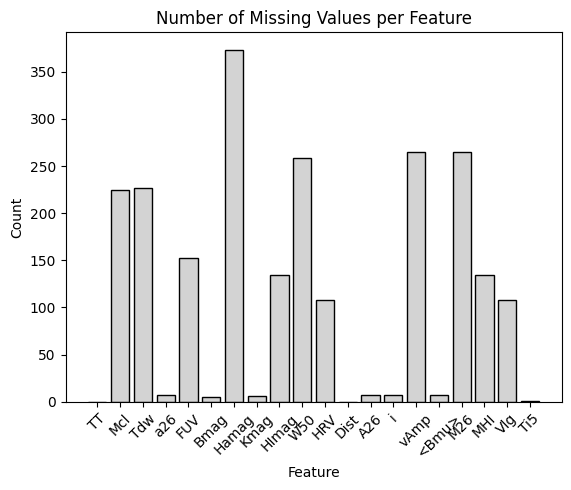

In [199]:
plt.bar(x=all_features,height=missing_num,edgecolor='black',color='lightgrey')
plt.xticks(rotation=45)
plt.xlabel('Feature')
plt.ylabel('Count')
plt.title("Number of Missing Values per Feature")
plt.show()

In [200]:
# check number of galaxies for each type
def get_elements(array,unique):

    unique_elements, counts = np.unique(array, return_counts=True)

    # Create an array representing how many values there are of each unique element
    count_array = np.zeros_like(unique_elements, dtype=int)

    for i, element in enumerate(unique_elements):
        count_array[i] = counts[i]
    
    try:
        unique_elements= [int(i) for i in unique_elements]
    except:
        pass

    

    combined = list(zip(unique_elements, count_array))

    # Sort the combined list based on the first element (the indexes)
    sorted_combined = sorted(combined, key=lambda x: x[0])

    # Extract the sorted indexes and values
    unique_elements, count_array = zip(*sorted_combined)

    return list(unique_elements),list(count_array)

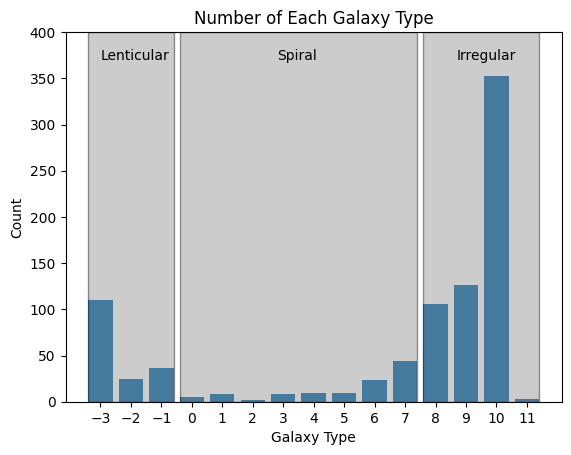

In [215]:
# unique_elements=  unique_elements.sort()

unique_elements,count_array= get_elements(galaxies_df['TT'])
plt.bar(x=unique_elements,height=count_array)
plt.xticks(unique_elements)

# highlight each galaxy type
plt.axvspan(-3.4,-.6,facecolor='grey',alpha=.4,linewidth=1,edgecolor='black')
plt.text(-3,370,s='Lenticular')
plt.axvspan(-.4,7.4,facecolor='grey',alpha=.4,linewidth=1,edgecolor='black')
plt.text(2.8,370,s='Spiral')
plt.axvspan(7.6,11.4,facecolor='grey',alpha=.4,linewidth=1,edgecolor='black')
plt.text(8.7,370,s='Irregular')
plt.ylim(0,400)

plt.xlabel("Galaxy Type")
plt.ylabel("Count")
plt.title("Number of Each Galaxy Type")

plt.show()


In [281]:
dwarf_brightnesses = ['H','N','L',"X"]

dwarf_colors = ['BCD','Im','Ir','dEem','dS0em','Tr','dE','Sph']

Text(0, 0.5, 'Count')

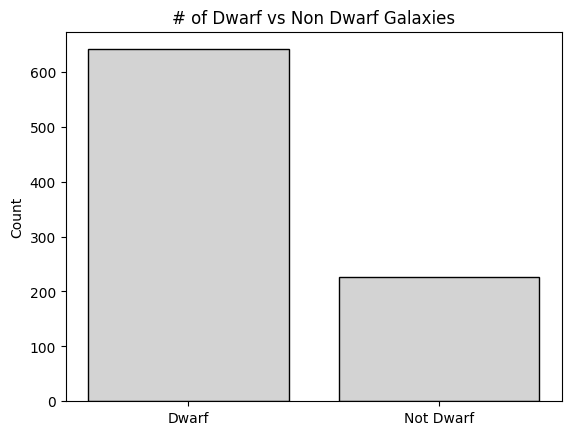

In [302]:
plt.bar(x=['Dwarf','Not Dwarf'],height=[len(dwarf),len(not_dwarf)],edgecolor='black',color='lightgrey')
plt.title("# of Dwarf vs Non Dwarf Galaxies")
plt.ylabel("Count")

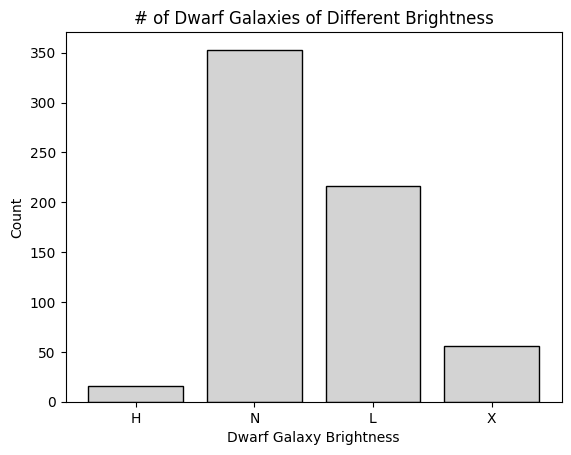

In [300]:
# when accounting for dwarf galaxies
brightnesses = np.array([i.strip() for i in galaxies_df['Tdw'][dwarf]])
counts = []
for i in dwarf_brightnesses:
    counts.append(np.count_nonzero(brightnesses == i))

# unique_elements,count_array= get_elements(galaxies_df['Tdw'][dwarf])
# unique_elements[0] = 'Not Dwarf'
plt.bar(x=dwarf_brightnesses,height=counts,edgecolor='black',color='lightgrey')
plt.xticks(unique_elements)
plt.xlabel("Dwarf Galaxy Brightness")
plt.ylabel("Count")
plt.title("# of Dwarf Galaxies of Different Brightness")


plt.show()

(0.0, 400.0)

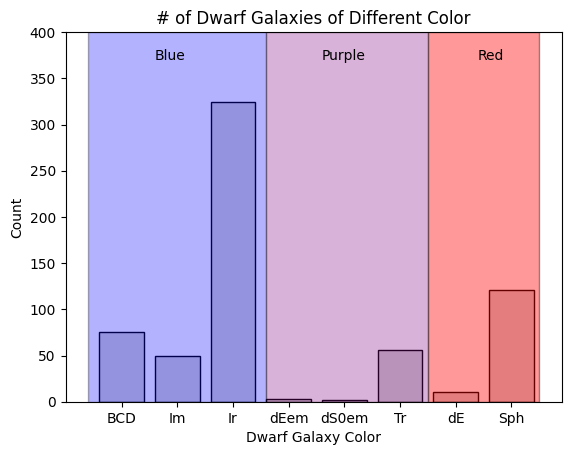

In [295]:
# when accounting for dwarf galaxies
colors = np.array([i.strip() for i in galaxies_df['Mcl'][dwarf]])
counts = []
for i in dwarf_colors:
    counts.append(np.count_nonzero(colors == i))




unique_elements,count_array= get_elements(colors)


fig, ax = plt.subplots()


bars = ax.bar(dwarf_colors, counts,edgecolor='black',color='lightgrey')
# plt.bar(x=dwarf_colors,height=counts,edgecolor='black',color='lightgrey')
plt.xticks(unique_elements)
plt.xlabel("Dwarf Galaxy Color")
plt.ylabel("Count")
plt.title("# of Dwarf Galaxies of Different Color")

# Get the width of the highlighted bar
# width = bars['BCD'].get_width()
# x_coord = bars['BCD'].get_x()

plt.axvspan(bars[0].get_x()-.2,bars[2].get_x()+1,facecolor='blue',alpha=.3,linewidth=1,edgecolor='black')
plt.text(bars[1].get_x(),370,s='Blue')
plt.axvspan(bars[2].get_x()+1,bars[5].get_x()+.9,facecolor='purple',alpha=.3,linewidth=1,edgecolor='black')
plt.text(bars[4].get_x(),370,s='Purple')
plt.axvspan(bars[5].get_x()+.9,bars[7].get_x()+.9,facecolor='red',alpha=.4,linewidth=1,edgecolor='black')
plt.text(bars[7].get_x()-.2,370,s='Red')
plt.ylim(0,400)

